## Building LSTMs with PyTorch

Today we are going to build LSTMs from scratch using PyTorch.

We'll implement the core LSTM cell and create a multi-layered model, gaining a deep understanding of how LSTMs process sequential data.

**Below information and images are mainly collected from below articles and references:**
    
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [LSTM: Understanding the Number of Parameters](https://www.kaggle.com/code/kmkarakaya/lstm-understanding-the-number-of-parameters)
    


In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [36]:
# Prepairing the MNIST dataset
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [38]:
img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [39]:
classes = train_dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# Building The Model

## LSTM Gates Explaination

* **Forget Gate:** Acts like a ruthless organizer, discarding irrelevant information from the past.
* **Input Gate:** This gatekeeper decides how much new information to consider and proposes potential additions.
* **Output Gate:** This curator selects what information from the cell state becomes the output.

These gates empower LSTMs to selectively remember and process information, enabling them to learn long-term dependencies in sequential data, a key advantage over vanilla RNNs.


<img src='/images/lstms_gates.png'>

 **explanation of the LSTMCell implementation:**

**Initialization:**
- Sets up model configuration (input size, hidden size) and creates linear layers for processing input and hidden state data.
- Initializes model parameters using a uniform distribution for better convergence during training.

**Forward Pass:**
1. **Unpacks hidden states:** Extracts previous hidden state (`hx`) and cell state (`cx`) from the provided tuple.
2. **Reshapes input:** Ensures batch dimension is first for consistency.
3. **Combines input and hidden information:** Transforms input and hidden state using linear layers and adds results.
4. **Splits gates:** Flattens combined information and divides it into four gates: input (`ingate`), forget (`forgetgate`), cell (`cellgate`), and output (`outgate`).
5. **Applies activation functions:** Sigmoid for `ingate` and `forgetgate`, tanh for `cellgate`, sigmoid for `outgate`.
6. **Updates cell state:** Selectively retains past information and incorporates new data based on input and forget gates.
7. **Calculates hidden state:** Applies output gate to filtered cell state.
8. **Returns new states:** Provides updated hidden state (`hy`) and cell state (`cy`) for use in the next timestep or layer.

**Key takeaway:** The LSTMCell class implements core computations of an LSTM cell, enabling it to learn long-term dependencies in sequences by selectively remembering and processing information over time.


In [41]:

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__() # Inherit from the nn.Module class

        # Store model configuration
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Create linear layers for input-to-hidden and hidden-to-hidden transformations
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)

        # Initialize model parameters
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize model parameters with uniform distribution for better convergence."""
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        """
        LSTM cell forward pass.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).
            hidden (tuple): Tuple containing previous hidden and cell states (h_0, c_0).

        Returns:
            tuple: Tuple containing the new hidden and cell states (h_1, c_1).
        """

        # Unpack previous hidden and cell states
        hx, cx = hidden

        # Reshape input tensor if needed
        x = x.view(-1, x.size(1))  # Ensures batch dimension is first

        # Combine input and hidden information
        gates = self.x2h(x) + self.h2h(hx)

        # Flatten gates tensor for readability
        gates = gates.squeeze()

        # Split gates into individual components for forget, input, cell, and output gates
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        # Apply activation functions to gates
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        # Update cell state
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)  # Combine old and new information

        # Calculate hidden state
        hy = torch.mul(outgate, torch.tanh(cy))  # Apply output gate to cell state

        # Return the new hidden and cell states for the next timestep
        return (hy, cy)


**1. Class Initialization (`__init__` function):**

   - **Configuration Parameters:**
      - The `__init__` function takes several arguments to configure the LSTM model:
         - `input_dim`: Dimensionality of the input data (e.g., number of features per time step).
         - `hidden_dim`: Size of the hidden state vector in the LSTM cell. This controls the model's memory capacity and ability to capture complex relationships within the data.
         - `layer_dim`: Number of stacked LSTM layers. A higher value allows for learning longer-term dependencies but increases model complexity.
         - `output_dim`: Dimensionality of the model's output (e.g., number of classes for classification or number of features for regression).

   - **Core LSTM Cell:**
      - An instance of the `LSTMCell` class, created earlier, is stored as `self.lstm`. This `LSTMCell` object performs the core computations for a single LSTM unit.

   - **Output Layer:**
      - A fully connected (linear) layer is created as `self.fc`. This layer takes the final hidden state from the LSTM as input and generates the model's prediction. The output dimension of this layer (`output_dim`) determines the number of classes or features in the model's output.

**2. Forward Pass (`forward` function):**

   - **Processing Input Sequences:**
      - The `forward` function takes the input data (`x`) as a tensor, typically with three dimensions:
         - Batch size (number of samples in the batch)
         - Sequence length (number of time steps in each sequence)
         - Input feature dimension (number of features per time step)

   - **Initializing Hidden and Cell States (h0, c0):**
      1. **Zero Tensors:** Two tensors, `h0` and `c0`, are created to represent the initial hidden and cell states for the LSTM layers. These are initialized with zeros, assuming no prior information about the sequence.
      2. **Correct Dimensions:** The dimensions of `h0` and `c0` are `(layer_dim, batch_size, hidden_dim)`.
         - `layer_dim`: Matches the number of stacked LSTM layers.
         - `batch_size`: Matches the batch size of the input data.
         - `hidden_dim`: Matches the hidden state dimension of the LSTM cell.
      3. **GPU Acceleration (Optional):**
         - The code checks if a GPU is available using `torch.cuda.is_available()`. If so, it moves `h0` and `c0` to the GPU for faster computations using `.cuda()`.

   - **Iterating Through the Sequence:**
      1. **Empty Output List:** An empty list `outs` is created to store the hidden states at each time step.
      2. **Unpacking Initial States:** The initial hidden state (`hn`) and cell state (`cn`) are extracted from the first layer of `h0` and `c0` (using `[0,:,:]`). This is because the LSTM processes sequences one step at a time.
      3. **Looping Through Time Steps:** The code iterates through the sequence length (`x.size(1)`) using a `for` loop:
         - **Current Input:** The current input for this time step is obtained by slicing the input tensor `x[:, seq, :]`. This selects all samples in the batch (`[:,]`) for the current time step (`seq`) and extracts all features (`[:]`).
         - **LSTM Processing:** The current input (`x[:, seq, :]`) along with the previous hidden and cell states (`hn`, `cn`) are fed to the `self.lstm` (LSTMCell) object. This performs the core LSTM computations, updating the hidden and cell states for the current time step.
         - **Updating States:** The new hidden state (`hn`) and cell state (`cn`) for the current time step are obtained from the LSTMCell's output.
         - **Storing Hidden State:** The new hidden state (`hn`) is appended to the `outs` list for later use.

   - **Obtaining Final Output:**
      1. **Extracting Last Hidden State:** The last hidden state from the `outs` list is retrieved. This represents the LSTM's output for the final time step of the sequence.
      2. **Removing Unnecessary Dimensions:** Since the fully connected layer expects a 2D tensor, any extra dimensions from the hidden state (due to stacking LSTM layers) are removed using `.squeeze()`.
      3. **Fully Connected Layer:** The final hidden state is passed

<img src="/images/LSTM3-chain.png">

<img src="/images/LSTM_internal2.png">

In [42]:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()  # Inherit from nn.Module class

        # Store model configuration
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Create LSTM cell instance
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)

        # Create fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Forward pass through the LSTM model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """

        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        # Move initial states to GPU if available
        if torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()

        # Create a list to store hidden states at each time step
        outs = []

        # Unpack initial hidden and cell states for the first layer
        cn = c0[0, :, :]
        hn = h0[0, :, :]

        # Iterate through the sequence time steps
        for seq in range(x.size(1)):
            # Process current input, hidden, and cell states through LSTM cell
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))

            # Store the hidden state for this time step
            outs.append(hn)

        # Extract the last hidden state
        out = outs[-1].squeeze()

        # Pass the last hidden state through the fully connected layer
        out = self.fc(out)

        return out

input_dim = 28
hidden_dim = 128
layer_dim = 1  # one or stacked layers
output_dim = len(classes)
seq_dim = 28

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [44]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.view(-1, seq_dim, input_dim) # Reshaping the inputs to be (BATCH_SIZE, TIMESTEP, INPUT_FEATURES)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [45]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.view(-1, seq_dim, input_dim)
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [46]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening

        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    # 6. Return the filled results at the end of the epochs
    return results

In [47]:
model_results = train(model, train_loader, test_loader, optimizer, loss_fn)

 20%|██        | 1/5 [00:23<01:32, 23.24s/it]

Epoch: 1 | train_loss: 2.2872 | train_acc: 0.1543 | test_loss: 2.2432 | test_acc: 0.1894


 40%|████      | 2/5 [00:44<01:05, 21.78s/it]

Epoch: 2 | train_loss: 1.4419 | train_acc: 0.5090 | test_loss: 0.7135 | test_acc: 0.7743


 60%|██████    | 3/5 [01:04<00:42, 21.34s/it]

Epoch: 3 | train_loss: 0.5196 | train_acc: 0.8379 | test_loss: 0.2926 | test_acc: 0.9170


 80%|████████  | 4/5 [01:26<00:21, 21.31s/it]

Epoch: 4 | train_loss: 0.2612 | train_acc: 0.9239 | test_loss: 0.2444 | test_acc: 0.9229


100%|██████████| 5/5 [01:47<00:00, 21.57s/it]

Epoch: 5 | train_loss: 0.1874 | train_acc: 0.9454 | test_loss: 0.1516 | test_acc: 0.9552


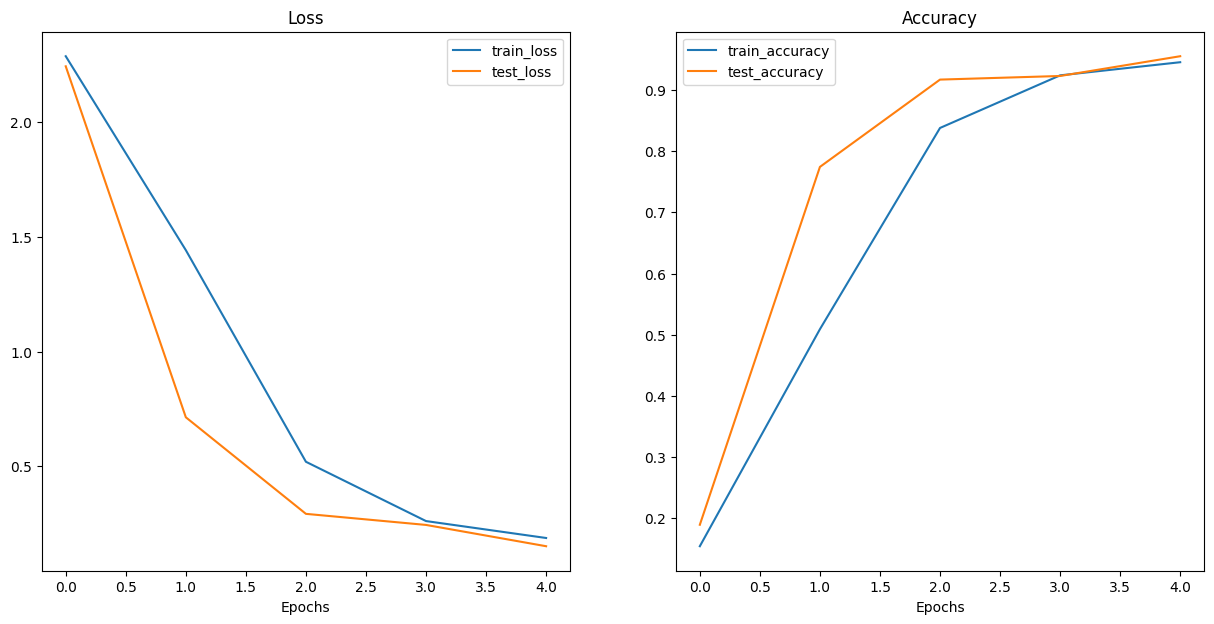

In [48]:
def plot_loss_curves(results):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

# Draft Cells

In [49]:
torch.manual_seed(42)
z = torch.randn(size=(32, 40))
y = z.clone()
x = z + y
x = x.squeeze()
x1, x2, x3, x4 = x.chunk(4, 1)
x.shape, x1.shape, x2.shape, x3.shape, x4.shape

(torch.Size([32, 40]),
 torch.Size([32, 10]),
 torch.Size([32, 10]),
 torch.Size([32, 10]),
 torch.Size([32, 10]))

In [50]:
# Understanding the view method used in LSTMCell
test = img.view(-1, 28, 28)
test.shape, test.dtype

(torch.Size([100, 28, 28]), torch.float32)